In [ ]:
import os
os.chdir("..")

import warnings
warnings.filterwarnings("ignore")

from utils import *
from runDeepSurvModels import *
from runSurvModels import *

## Optuna dashboard

In [3]:
study = optuna.load_study(storage="sqlite:///deepsurv-torch-hp-log.db", study_name="BE00Asso00_normNone-nl-sine-5000")
optuna.visualization.plot_optimization_history(study).show() # Optimization records
optuna.visualization.plot_param_importances(study).show()  # Hyperparam importance

## ***CAUTION!*** Rename model results files

In [4]:
import re

for root, dirname, files in os.walk("data/BE10Asso10_normDEseq"):
    
    for f in files:
        if f.endswith("_080125.csv"):
            old = os.path.join(root, f)
            # print(old)
            new = re.sub(pattern="_080125.csv", repl="_072125.csv", string=old)
            print(new)
            os.rename(old, new)
            
    # if os.path.basename(root) == "stratified-lasso":
    #     for f in files:   
    #         if f.startswith("model_results_2000_082825.csv"):
    #             old = os.path.join(root, f)
    #             # print(old)
    #             new = os.path.join(root, "model_results_rerun_5000.csv")
    #             print(new)
    #             os.rename(old, new)

data/BE10Asso10_normDEseq/nl-quadratic/simSurvival_nl-quadratic_train_90000_072125.csv
data/BE10Asso10_normDEseq/nl-quadratic/simSurvival_nl-quadratic_test_10000_072125.csv
data/BE10Asso10_normDEseq/nl-quadratic/beta0_nl-quadratic_072125.csv
data/BE10Asso10_normDEseq/nl-shiftquad/simSurvival_nl-shiftquad_train_90000_072125.csv
data/BE10Asso10_normDEseq/nl-shiftquad/simSurvival_nl-shiftquad_test_10000_072125.csv
data/BE10Asso10_normDEseq/nl-shiftquad/beta0_nl-shiftquad_072125.csv
data/BE10Asso10_normDEseq/nl-interaction/simSurvival_nl-interaction_train_90000_072125.csv
data/BE10Asso10_normDEseq/nl-interaction/simSurvival_nl-interaction_test_10000_072125.csv
data/BE10Asso10_normDEseq/nl-interaction/beta0_nl-interaction_072125.csv
data/BE10Asso10_normDEseq/nl-sine/simSurvival_nl-sine_train_90000_072125.csv
data/BE10Asso10_normDEseq/nl-sine/simSurvival_nl-sine_test_10000_072125.csv
data/BE10Asso10_normDEseq/nl-sine/beta0_nl-sine_072125.csv


## Test Experiments

Training data dimensions: (90000, 541)
Testing data dimensions:  (10000, 541)
Survival time distribution:
Event rate in train set: 0.753044
Event rate in test set: 0.752100
Survival time distribution:


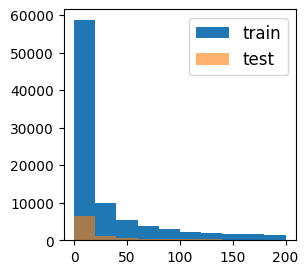

In [2]:
# Load data
batchNormType='BE10Asso10_normNone' #'BE00Asso00_normNone'
dataName='linear-weak'
keywords = ['']

train_df, test_df = load_simulate_survival_data(batchNormType=batchNormType,
                                                dataName=dataName,
                                                keywords=keywords, 
                                                keep_batch=True)

# observe data
print(f"Training data dimensions: {train_df.shape}")
print(f"Testing data dimensions:  {test_df.shape}")
print('Survival time distribution:')
plot_simulation_data(train_df, test_df)

### RSF

In [4]:
n=10000
run=1
splits=10 
status_col = "status"
time_col = "time"
batch_col = "batch.id"
test_size = 1000

train_sub, _ = train_test_split(train_df, train_size=n, 
                                stratify=train_df[[status_col, batch_col]],
                                shuffle=True, random_state=run)
test_sub, _  = train_test_split(test_df,
                                train_size=test_size,
                                stratify=test_df[[status_col, batch_col]],
                                shuffle=True, random_state=run)
                
### NOTE: conversion to scikitsurv format assumes no batch.id column
X_train, y_train = dataframe_to_scikitsurv_ds(train_sub.drop(columns=batch_col))
X_test, y_test = dataframe_to_scikitsurv_ds(test_sub.drop(columns=batch_col))

In [5]:
model = RandomSurvivalForest(n_estimators=5)
start = time.time()
model.fit(X_train, y_train)
duration = round(time.time() - start, 2)


In [ ]:
model.

RandomSurvivalForest(n_estimators=5)

In [8]:

# ==================== Evaluation ====================
# Concordance index ----------------
train_c = model.score(X_train, y_train)
test_c = model.score(X_test, y_test)

print(train_c, test_c)
# Integrated Brier score -----------
try:
    min_t = np.ceil(max(y_train[self.time_col].min(), y_test[self.time_col].min()))
    max_t = np.floor(min(y_train[self.time_col].max(), y_test[self.time_col].max()))
    times = np.linspace(min_t, max_t, 20)

    preds_train = np.asarray([[fn(t) for t in times] for fn in model.predict_survival_function(X_train)])
    preds_test = np.asarray([[fn(t) for t in times] for fn in model.predict_survival_function(X_test)])

    train_brier = integrated_brier_score(y_train, y_train, preds_train, times)
    test_brier = integrated_brier_score(y_train, y_test, preds_test, times)
except:
    print("no brier score")


0.8757487366565319 0.6803172072336676
no brier score


In [ ]:
model_results.append({
    "n train": n,
    "train time": duration,
    "train C": tr_cind,
    "test C": te_cind,
    "train brier": tr_brier,
    "test brier": te_brier
})

### DeepSurv

In [5]:
study = optuna.load_study(storage="sqlite:///deepsurv-torch-hp-log-1.db", study_name="BE10Asso10_normNone-linear-weak-5000")
# optuna.visualization.plot_optimization_history(study).show() # Optimization records
# optuna.visualization.plot_param_importances(study).show()  # Hyperparam importance
study.best_params

{'num_nodes': [64],
 'dropout': 0.19800080147148458,
 'learning_rate': 0.002826948448361378,
 'weight_decay': 0.02709129692865335,
 'batch_size': 32}

In [6]:
optuna.delete_study(storage="sqlite:///deepsurv-torch-hp-log-1.db", study_name="BE10Asso10_normNone-linear-weak-5000")

In [7]:
subset_sizes=[5000]#[100, 500, 1000, 2000, 5000]
run_per_size=[20]#,20,20,20,20]
splits_per_size=[10]#[3,5,5,10,10]
trials_per_size=[50]#,20,20,30,30]
hyperparameters = {
    "learning_rate": {"type": "float", "low": 1e-4, "high": 1e-2, "log": True},
    "num_nodes": {"type": "categorical", "choices": [[64], [32,16], [64,32], [128,64], [64,64,32],[32,32,16]]},
    "dropout": {"type": "float", "low": 0.1, "high": 0.5},
    "weight_decay": {"type": "float", "low": 1e-5, "high": 1e-2, "log": True},
    "batch_size": {"type": "categorical", "choices": [32, 64, 128]},
}

ds = DeepSurvPipeline(
    train_df, test_df, 
    batchNormType=batchNormType, 
    dataName=dataName,
    hyperparameters=hyperparameters,
    storage_url="sqlite:///deepsurv-torch-hp-log-1.db",
)
# optuna.logging.disable_default_handler()
model_results = ds.train_over_subsets(subset_sizes=subset_sizes, 
                                runs_per_size=run_per_size, 
                                splits_per_size=splits_per_size,
                                trials_per_size=trials_per_size,
                                is_tune=True, 
                                is_save=False, 
                                n_jobs=1,
                                trial_threshold=100
)
# ds.write(model_results)
model_results

Running for N=5000...


[I 2025-09-08 15:42:42,890] A new study created in RDB with name: BE10Asso10_normNone-linear-weak-5000


Starting hyperparam tuning: ['learning_rate', 'num_nodes', 'dropout', 'weight_decay', 'batch_size']


[I 2025-09-08 15:43:03,420] Trial 0 finished with value: 0.5134536450981294 and parameters: {'learning_rate': 0.001045290575662191, 'num_nodes': [32, 16], 'dropout': 0.13016961759462348, 'weight_decay': 0.002634653289428582, 'batch_size': 128}. Best is trial 0 with value: 0.5134536450981294.
[I 2025-09-08 15:43:22,411] Trial 1 finished with value: 0.5247800023373872 and parameters: {'learning_rate': 0.004637169143701122, 'num_nodes': [64], 'dropout': 0.18288237331331425, 'weight_decay': 0.002781160166244679, 'batch_size': 128}. Best is trial 1 with value: 0.5247800023373872.
[I 2025-09-08 15:44:28,478] Trial 2 finished with value: 0.5122520480103476 and parameters: {'learning_rate': 0.00018231550580344446, 'num_nodes': [64, 32], 'dropout': 0.23291973258210336, 'weight_decay': 0.0016202125339367256, 'batch_size': 32}. Best is trial 1 with value: 0.5247800023373872.
[I 2025-09-08 15:45:25,709] Trial 3 finished with value: 0.529976181382346 and parameters: {'learning_rate': 0.000815383570

Found best hyperparameters: {'learning_rate': 0.004842891036780486, 'num_nodes': [32, 16], 'dropout': 0.45102450855157794, 'weight_decay': 0.0066511340207376715, 'batch_size': 64}
(Avg. runtime: 3.68s)   |                (C-index)  Train: 0.562, Test: 0.555   |                (Brier)  Train: 0.17, Test: 0.169 (Mean)



,n train,train time,train C,test C,train brier,test brier
0,5000,3.49,0.574163,0.555755,0.169241,0.168115
1,5000,2.77,0.517444,0.551826,0.170492,0.168101
2,5000,5.45,0.569760,0.560399,0.168368,0.168944
3,5000,2.98,0.558076,0.569522,0.168174,0.170548
4,5000,3.25,0.576593,0.562332,0.170145,0.177489
5,5000,3.58,0.553874,0.568402,0.170008,0.169236
6,5000,3.32,0.571523,0.549770,0.169164,0.170805
7,5000,3.48,0.559063,0.566137,0.169586,0.167988
8,5000,3.91,0.567324,0.552358,0.169677,0.171510
9,5000,4.18,0.557302,0.563414,0.168952,0.164116
